# Free Spoken Digit classification

In this exercise you will build a complete data analytics pipeline to pre-process your audio signals and build a classification model able to distinguish between the classes available in the dataset.

More specifically, you will load, analyze and prepare the Free Spoken Digit dataset to train and validate a classification model.

# Analyzing the dataset

## 1. Load the dataset from the root folder 

### Dataset organization
The dataset archive is organized as follows:
- dev: the folder that contains the labeled recordings;
- eval: the folder that contains the unlabeled recordings. Use this data to produce the submission file
containing the predicted labels.

In [1]:
from os import listdir
from os.path import join

root_folder : str   = 'dataset'
dev         : str   = 'development'
eval        : str   = 'evaluation'

dev_files   : list[str] = listdir(join(root_folder, dev))
eval_files  : list[str] = listdir(join(root_folder, eval))

print(f'Development .wav file names: {dev_files[:5]}')
print(f'Evaluation .wav file names: {eval_files[:5]}')

Development .wav file names: ['0_4.wav', '1000_0.wav', '1001_1.wav', '1002_6.wav', '1003_2.wav']
Evaluation .wav file names: ['0.wav', '1.wav', '10.wav', '100.wav', '101.wav']


### Converting the Data set into an usefull format

Create a data frame for storing all the information of the recordings

In [2]:
from scipy.io.wavfile import read as read_wav # read .wav files

def convert_files_for_df(file_list : list[str], options : str = 'dev') -> list[dict]:
    """Convert element of the given list to the proper format

    Args:
        file_list (list[str]): Input list to be converted
        options (str, optional): Information on how to the input strings are formatted:
            - 'dev' (default) => format is '<idx>_<label>.wav'
            - 'eval' => format is '<idx>.wav'

    Returns:
        converted_data (list[dict]): each converted element is in a separate dict
    """
    splitted : list[list[str]] = [element.replace('.', '_').split('_')[:-1] for element in file_list]
    
    if options == 'eval':
        return [{'idx' : int(input_str[0]), 'full_path': join(root_folder, eval, file_list[i]), 'wav_data' : read_wav(join(root_folder, eval, file_list[i]))} for i, input_str in enumerate(splitted)]
    else: # default
        return [{'idx' : int(col[0]), 'label' : int(col[1]), 'full_path' : join(root_folder, dev, file_list[i]), 'wav_data' : read_wav(join(root_folder, dev, file_list[i]))} for i, col in enumerate(splitted)]

In [3]:
#  Convert the development dataset in a pandas data frame, with index 'idx' and columns ['label', 'full_path', 'wav_data']
import pandas as pd # create data frame

dev_dataset : pd.DataFrame = pd.DataFrame(data = convert_files_for_df(dev_files)).set_index('idx').sort_index()

print(dev_dataset.head(5))
print('\nDataset information:')
print(dev_dataset.info(10))

     label                    full_path  \
idx                                       
0        4  dataset\development\0_4.wav   
1        7  dataset\development\1_7.wav   
2        5  dataset\development\2_5.wav   
3        2  dataset\development\3_2.wav   
4        3  dataset\development\4_3.wav   

                                              wav_data  
idx                                                     
0    (8000, [14, 21, 0, 18, -11, 22, -15, -53, 9, -...  
1    (8000, [-2, 12, 1, -18, 7, -7, 1, -1, 0, 0, -6...  
2    (8000, [-9, -7, -5, -8, -13, -1, 20, -12, 6, 1...  
3    (8000, [-256, -512, 0, -256, 256, -256, 0, -51...  
4    (8000, [-20, 10, 26, -13, 22, -16, 11, 7, -21,...  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1500 non-null   int64 
 1   full_path  1500 non-null   object
 2   wav_data   1500

## 2. Analyze the wav_data column

Let us analyze what the wav_data column contains, using the first element of the data frame as an example

In [ ]:
test_element : pd.Series = dev_dataset.iloc[0]
print(test_element)

label                                                        7
full_path                         dataset\development\18_7.wav
wav_data     (8000, [-256, -512, 0, -512, 0, -256, -512, 0,...
Name: 18, dtype: object


Each wav file return a samplerate and a data array

In [142]:
sample_rate, data = test_element['wav_data']

print(f'Sample rate = {sample_rate}')
print(f'Data shape: {data.shape}, Data type (audio resolution): {data.dtype}')

Sample rate = 8000
Data shape: (2882,), Data type (audio resolution): int16


data.shape is and 1-D array, meaning that we only have 1 audio channel. With the length of the array and the sample rate, we can also calculate the duration of the audio recording

In [143]:
time_length : float =  data.shape[0] / sample_rate
print(f'Duration of the audio recording = {time_length} seconds')

Duration of the audio recording = 0.36025 seconds


We can also visualize the waveform with a plot

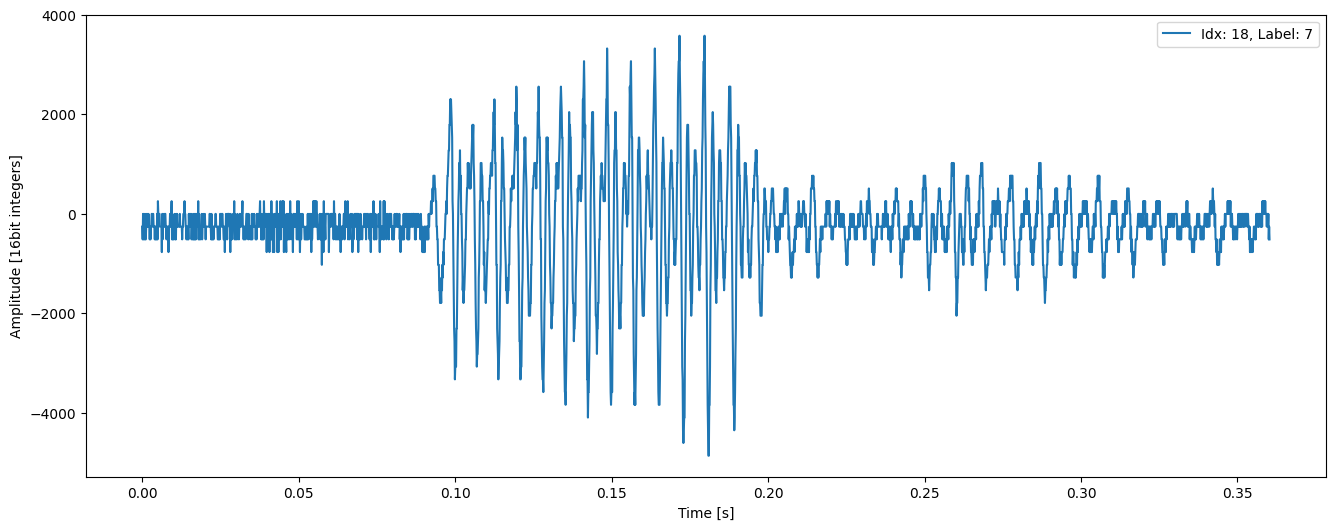

In [144]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize = (16, 6)) # create figure

time_axis = np.linspace(0.0, time_length, data.shape[0]) # create x axis
ax.plot(time_axis, data, label = f'Idx: {test_element.name}, Label: {test_element['label']}') # plot
ax.set_xlabel(xlabel = 'Time [s]')
ax.set_ylabel(ylabel = 'Amplitude [16bit integers]')
ax.legend()

plt.show()